In this notebook, we will try to build a very simple model to predict the outcome of tennis matched.  This is an ELO model.  Specifically, we will model

$$p(y_1) = \sigma(\beta_1 - \beta_2)$$, where $$\beta_1$$ and $$\beta_2$$ are coefficients for players 1 and 2 respectively

In [1]:
from infra.defs import DATA_DIR
import pandas as pd
import os

match_result_dir = os.path.join(DATA_DIR, 'match_results')

df = pd.concat([
    pd.read_csv(os.path.join(match_result_dir, f)) for f in os.listdir(match_result_dir)
])

In [2]:
df.rename(columns={x: x.lower() for x in df.columns}, inplace=True)

In [3]:
# Drop rows with no result

df.dropna(subset=['winner', 'loser'], inplace=True)

In [4]:
df.shape

(50784, 59)

50k matches to work with

#### Explore Player Frequencies

In [9]:
# Convert dates to datetimes
df['date'] = pd.to_datetime(df['date'])

In [11]:
player_set = set(df['winner']) | set(df['loser'])
n_players = len(player_set)
n_players

1461

1461 total players.  Let's look at player frequency:

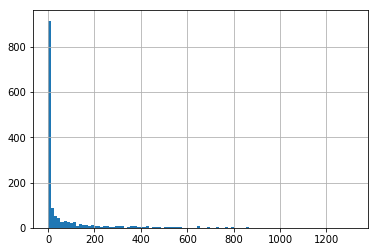

In [12]:
%matplotlib inline
all_players = pd.Series(df['winner'].tolist() + df['loser'].tolist())
all_players.value_counts().hist(bins=100)

There is clearly a long tail.  There are certain players that have played a lot of matches over this time period, and lots of players with very few

In [13]:
all_players.value_counts().value_counts().head()

1    346
2    180
3     92
4     63
5     53
dtype: int64

In [14]:
all_players.value_counts().head(20)

Federer R.          1313
Nadal R.            1051
Ferrer D.           1040
Djokovic N.          914
Berdych T.           886
Robredo T.           861
Youzhny M.           860
Lopez F.             856
Verdasco F.          850
Murray A.            801
Davydenko N.         790
Roddick A.           773
Gasquet R.           770
Kohlschreiber P.     729
Hewitt L.            727
Simon G.             721
Wawrinka S.          698
Nieminen J.          695
Haas T.              691
Ferrero J.C.         682
dtype: int64

The players who appear most often are the best players...

#### Get player indices

In [15]:
player_idx_dict = dict(list(enumerate(player_set)))
player_mapping = {v: k for k, v in player_idx_dict.iteritems()}

In [32]:
n_players = len(player_mapping)
n_players

1461

In [19]:
df['winner_idx'] = df['winner'].map(lambda x: player_mapping[x])
df['loser_idx'] = df['loser'].map(lambda x: player_mapping[x])

#### Set up training data

First, we'll just try training on everything in this time period and see what happens.  Later, we will split into train and test sets and figure out appropriate discounting, etc.

In [53]:
# Shuffle winners and losers so y can have both 0's and 1's.

df['__chooser__'] = np.random.binomial(1, 0.5, size=df.shape[0])
df['p1_idx'] = df.apply(
    lambda row: row['winner_idx'] if row['__chooser__'] == 1 else row['loser_idx'],
    axis=1
)
df['p2_idx'] = df.apply(
    lambda row: row['winner_idx'] if row['__chooser__'] == 0 else row['loser_idx'],
    axis=1
)
df['y'] = df['__chooser__'] 

In [57]:
df[[
    'winner_idx',
    'loser_idx',
    '__chooser__',
    'p1_idx',
    'p2_idx',
    'y'
]].head()

,winner_idx,loser_idx,__chooser__,p1_idx,p2_idx,y
0,1003,174,1,1003,174,1
1,112,1398,1,112,1398,1
2,107,593,0,593,107,0
3,802,562,0,562,802,0
4,1066,156,0,156,1066,0


In [58]:
from scipy.sparse import csc_matrix
import numpy as np

n = df.shape[0]
p1_data = np.ones(n)
p1_row = np.arange(n)
p1_col = df['p1_idx'].values

p2_data = -np.ones(n)
p2_row = np.arange(n)
p2_col = df['p2_idx'].values
all_data = np.concatenate([p1_data, p2_data])
all_row = np.concatenate([p1_row, p2_row])
all_col = np.concatenate([p1_col, p2_col])

X = csc_matrix((all_data, (all_row, all_col)), shape=(n, n_players))

In [59]:
assert ((X != 0).sum(axis=1) == 2).all()

In [61]:
y = df['y']

In [62]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(fit_intercept=False)
logit.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [63]:
logit.coef_

array([[ 0.22191496, -0.25626623,  3.19977424, ..., -0.05375489,
        -0.4447485 ,  0.18612639]])

In [74]:
def describe_result(logit_mod):
    coef_df = pd.DataFrame(
        list(enumerate(logit_mod.coef_[0])),
        columns=['player_idx', 'coef']
    )
    coef_df['player_name'] = coef_df['player_idx'].map(lambda x: player_idx_dict[x])
    return coef_df.sort_values(by='coef', ascending=False)

describe_result(logit)

,player_idx,coef,player_name
2,2,3.199774,Djokovic N.
802,802,3.101990,Federer R.
55,55,3.067397,Nadal R.
290,290,2.732722,Murray A.
1254,1254,2.349848,Roddick A.
941,941,2.323876,Agassi A.
749,749,2.295886,Del Potro J.M.
1226,1226,2.122364,Tsonga J.W.
1068,1068,2.074555,Hewitt L.
1223,1223,2.025943,Raonic M.
